In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (12,10)

In [241]:
str_files = ''
#Carrega os dados do arquivo .csv
ugrhi06 = pd.read_csv(str_files + "cetesb_concatenado06semoutlier.csv",encoding='utf-8',sep=',')

#Carrega os dados do arquivo .csv
ugrhi10 = pd.read_csv(str_files + "cetesb_concatenado10semoutlier.csv",encoding='utf-8',sep=',')

In [236]:
print('---- Tamanho dos conjuntos originais ----')
print('X:',len(ugrhi06))
print('y:',len(ugrhi10))

#Seleciona os dados equivalente ao tamanho da URGHI10
X = ugrhi06.iloc[0:398]
#Remove a coluna ph, pois os seus valores serão preditos na UGRHI10
X = X.drop(['ph'],axis = 1).values
#Seleciona os valores da coluna ph da URGHI06, na qual será utilizado para a normalização dos dados quando apresentar o gráfico
train_previsao = ugrhi06['ph'].values
#Seleciona os valores da coluna ph da URGHI10.
y = ugrhi10['ph'].values

X = X.reshape(len(X),7)
y = y.reshape(len(y),1)
train_previsao = train_previsao.reshape(len(train_previsao),1)


assert X.shape == (len(X),7)
assert y.shape == (len(y),1)

print('---- Conjunto de dados y igualado ao tamanho de dados do conjunto X ----')
print('X:',len(X))
print('y:',len(y))


---- Tamanho dos conjuntos originais ----
X: 420
y: 398
---- Conjunto de dados y igualado ao tamanho de dados do conjunto X ----
X: 398
y: 398


In [237]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
X = sc.fit_transform(X)
y = sc.fit_transform(y)

#Normalização dos dados de previsão para teste
normalizador_previsao = MinMaxScaler()
normalizador_previsao.fit_transform(train_previsao)

array([[0.72444444],
       [0.72539683],
       [0.66787879],
       [0.63555556],
       [0.53333333],
       [0.94      ],
       [0.63666667],
       [0.08571429],
       [0.53333333],
       [0.66533333],
       [0.13333333],
       [0.13333333],
       [0.7       ],
       [0.26666667],
       [0.48086389],
       [0.88666667],
       [0.24444444],
       [0.6       ],
       [0.56666667],
       [0.445     ],
       [0.48086389],
       [0.93333333],
       [0.        ],
       [0.22222222],
       [0.78333333],
       [0.44833333],
       [0.2       ],
       [0.77333333],
       [0.49213755],
       [0.5       ],
       [0.525     ],
       [0.8       ],
       [0.26666667],
       [0.4       ],
       [0.13333333],
       [0.46666667],
       [0.21666667],
       [0.41666667],
       [0.64444444],
       [0.26666667],
       [0.33333333],
       [0.3       ],
       [0.76666667],
       [0.56666667],
       [0.37333333],
       [0.72666667],
       [0.44074074],
       [0.633

In [239]:
#Funções para cálculos das métricas de desempenho e ajuste da estrutura dos dados.
'''
def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape
'''

def mape(y_pred,y_true):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

#Função para calcular o coeficiente de determinação entre os valores observados e preditos.
#Calcula-se a correlação entre os valores observados e preditos e eleva ao expoente 2.
def correlacao_determinacao(dtframe,tipo):
    
    if (tipo == 0): #Treino
        resultado = dtframe.corr().previsao_treino.values[1] ** 2 
        
    else: #teste
        resultado = dtframe.corr().previsao_teste.values[1] ** 2
            
    return resultado

def pegar_dados_coluna_test(trainingd,percent,index_coluna):
    data = trainingd.iloc[:,:].values
    train_previsao = trainingd.iloc[0:int(len(data)*percent),index_coluna:index_coluna+1].values
           
    return train_previsao

def ajusta_lista(array):
    lista = []
    
    for i in range(len(array)):
        lista.append(array[i][0])
            
    return lista

#Monta o Dataframe para calcular a correlação e coeficiente de determinação entre os valores observados e preditos.
def df_correlacao(previsoes_treino,treino,previsoes,observado_test):
    
    #print(ajusta_lista(treino))
    
    df_corr_determinacao_treino = pd.DataFrame()
    df_corr_determinacao_teste  = pd.DataFrame()
      
    #Calcula o coeficiente de determinação
    
    dict = {'previsao_treino': ajusta_lista(previsoes_treino), 'treino': ajusta_lista(treino)} 
        
    df_treino = pd.DataFrame(dict)
    dframes_treino = [df_corr_determinacao_treino,df_treino]
    df_corr_determinacao_treino = pd.concat(dframes_treino)
    
    dict = {'previsao_teste': ajusta_lista(previsoes), 'teste': ajusta_lista(observado_test)} 
    
    df_teste = pd.DataFrame(dict)
    dframes_teste = [df_corr_determinacao_teste,df_teste]
    df_corr_determinacao_teste = pd.concat(dframes_teste)
    
    r_treino = round(correlacao_determinacao(df_corr_determinacao_treino,0),4)
    r_teste  = round(correlacao_determinacao(df_corr_determinacao_teste,1),4)
                
    return r_treino,r_teste

In [238]:
#Separação dos dados para treinamento(70%) e teste(30%)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)


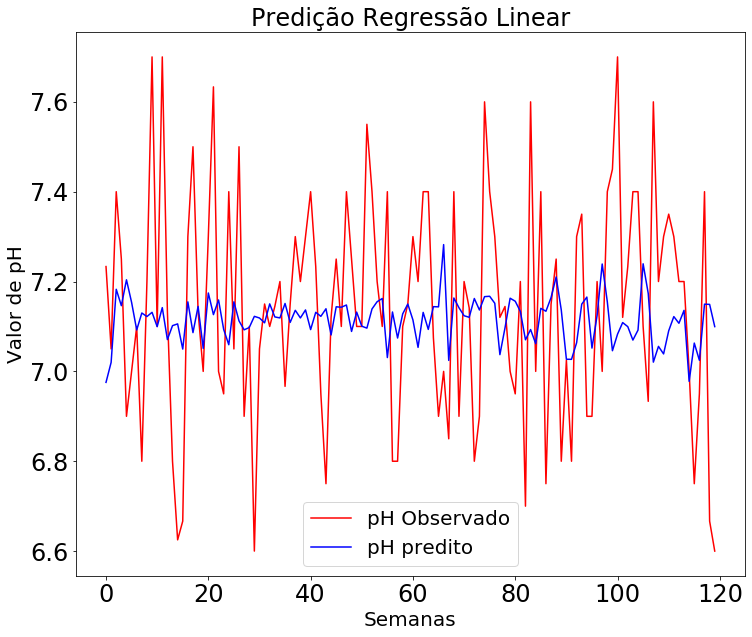

r_teste: 0.0


/home/anderson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


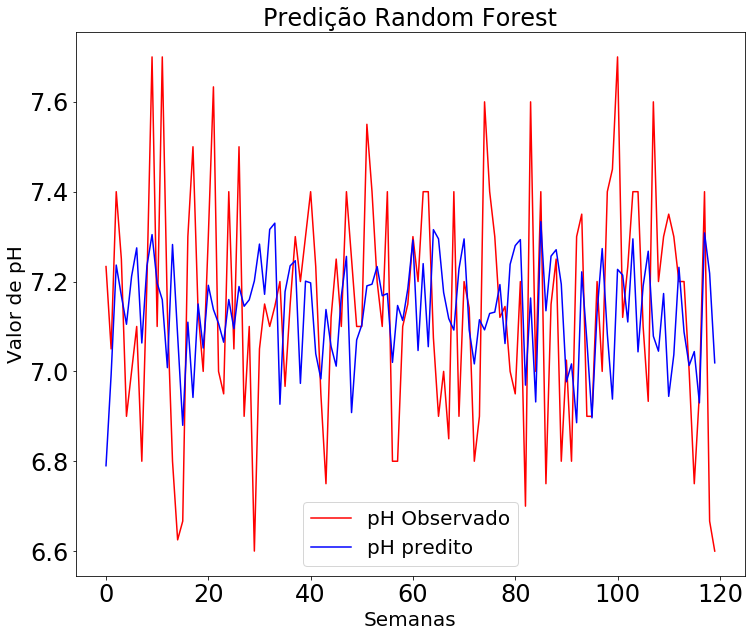

r_teste: 0.0236
Train on 278 samples
Epoch 1/100
278/278 [==============================] - 2s 5ms/sample - loss: 0.5672 - mean_absolute_error: 0.5672
Epoch 2/100
278/278 [==============================] - 0s 343us/sample - loss: 0.4212 - mean_absolute_error: 0.4212
Epoch 3/100
278/278 [==============================] - 0s 271us/sample - loss: 0.3028 - mean_absolute_error: 0.3028
Epoch 4/100
278/278 [==============================] - 0s 328us/sample - loss: 0.2319 - mean_absolute_error: 0.2319
Epoch 5/100
278/278 [==============================] - 0s 313us/sample - loss: 0.2169 - mean_absolute_error: 0.2169
Epoch 6/100
278/278 [==============================] - 0s 349us/sample - loss: 0.2111 - mean_absolute_error: 0.2111
Epoch 7/100
278/278 [==============================] - 0s 302us/sample - loss: 0.2015 - mean_absolute_error: 0.2015
Epoch 8/100
278/278 [==============================] - 0s 262us/sample - loss: 0.1934 - mean_absolute_error: 0.1934
Epoch 9/100
278/278 [================

278/278 [==============================] - 0s 296us/sample - loss: 0.1513 - mean_absolute_error: 0.1513
Epoch 69/100
278/278 [==============================] - ETA: 0s - loss: 0.1505 - mean_absolute_error: 0.150 - 0s 333us/sample - loss: 0.1514 - mean_absolute_error: 0.1514
Epoch 70/100
278/278 [==============================] - 0s 298us/sample - loss: 0.1509 - mean_absolute_error: 0.1509
Epoch 71/100
278/278 [==============================] - 0s 302us/sample - loss: 0.1520 - mean_absolute_error: 0.1520
Epoch 72/100
278/278 [==============================] - 0s 264us/sample - loss: 0.1521 - mean_absolute_error: 0.1521
Epoch 73/100
278/278 [==============================] - 0s 345us/sample - loss: 0.1510 - mean_absolute_error: 0.1510
Epoch 74/100
278/278 [==============================] - 0s 320us/sample - loss: 0.1525 - mean_absolute_error: 0.1525
Epoch 75/100
278/278 [==============================] - 0s 342us/sample - loss: 0.1509 - mean_absolute_error: 0.1509
Epoch 76/100
278/278 [=

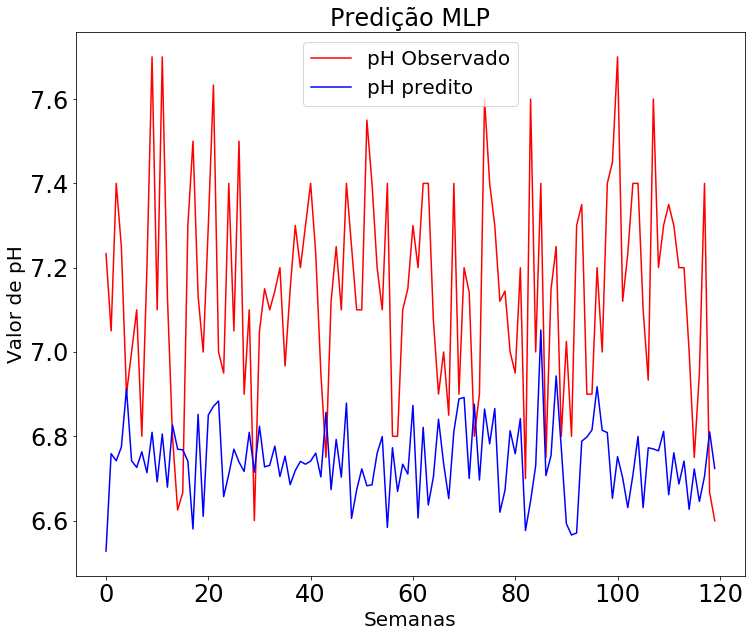

r_teste: 0.0025
Train on 278 samples
Epoch 1/100
278/278 [==============================] - 6s 21ms/sample - loss: 0.5728 - mean_absolute_error: 0.5728
Epoch 2/100
278/278 [==============================] - 0s 899us/sample - loss: 0.4743 - mean_absolute_error: 0.4743
Epoch 3/100
278/278 [==============================] - 0s 800us/sample - loss: 0.3919 - mean_absolute_error: 0.3919
Epoch 4/100
278/278 [==============================] - 0s 869us/sample - loss: 0.3155 - mean_absolute_error: 0.3155
Epoch 5/100
278/278 [==============================] - 0s 815us/sample - loss: 0.2492 - mean_absolute_error: 0.2492
Epoch 6/100
278/278 [==============================] - 0s 848us/sample - loss: 0.2086 - mean_absolute_error: 0.2086
Epoch 7/100
278/278 [==============================] - 0s 766us/sample - loss: 0.1820 - mean_absolute_error: 0.1820
Epoch 8/100
278/278 [==============================] - 0s 800us/sample - loss: 0.1885 - mean_absolute_error: 0.1885
Epoch 9/100
278/278 [===============

Epoch 71/100
278/278 [==============================] - 0s 909us/sample - loss: 0.1699 - mean_absolute_error: 0.1699
Epoch 72/100
278/278 [==============================] - 0s 931us/sample - loss: 0.1680 - mean_absolute_error: 0.1680
Epoch 73/100
278/278 [==============================] - 0s 884us/sample - loss: 0.1647 - mean_absolute_error: 0.1647
Epoch 74/100
278/278 [==============================] - 0s 842us/sample - loss: 0.1684 - mean_absolute_error: 0.1684
Epoch 75/100
278/278 [==============================] - 0s 853us/sample - loss: 0.1714 - mean_absolute_error: 0.1714
Epoch 76/100
278/278 [==============================] - 0s 775us/sample - loss: 0.1670 - mean_absolute_error: 0.1670
Epoch 77/100
278/278 [==============================] - 0s 725us/sample - loss: 0.1748 - mean_absolute_error: 0.1748
Epoch 78/100
278/278 [==============================] - 0s 848us/sample - loss: 0.1697 - mean_absolute_error: 0.1697
Epoch 79/100
278/278 [==============================] - 0s 841us

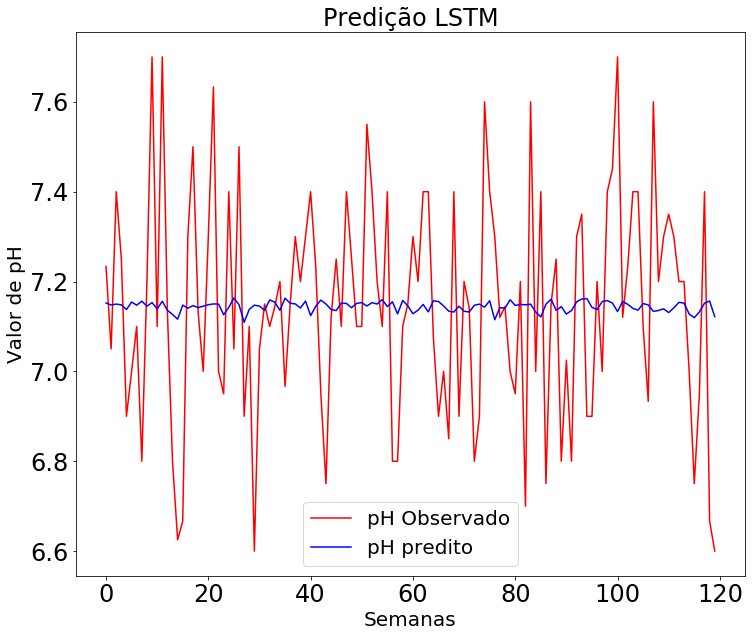

r_teste: 0.0057


In [240]:
am = ['rl','rf','mlp','lstm']

for t in am:
    if t == 'rl':
        model = LinearRegression()
        
        #Treina o modelo
        model.fit(X_train,y_train)
        
        #Predição dos dados de teste
        y_pred = model.predict(X_test)

        y_pred_rl = sc.inverse_transform(y_pred)

        X_test_rl = sc.inverse_transform(X_test)
        y_test_rl = sc.inverse_transform(y_test)
        
        #Predição dos dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_rl = sc.inverse_transform(y_predt)
        
        y_train_rl = sc.inverse_transform(y_train)
               
        plt.plot(y_test_rl,color='red', label='pH Observado')
        plt.plot(y_pred_rl,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição Regressão Linear')
        plt.show()
        
        mape_treino_rl       = round(mape(y_predt_rl,y_train_rl),4)
        rmse_treino_rl       = round(rmse(y_predt_rl,y_train_rl),4)
                
        mape_teste_rl        = round(mape(y_pred_rl,y_test_rl),4)
        rmse_teste_rl        = round(rmse(y_pred_rl,y_test_rl),4)
                
        r_treino_rl,r_teste_rl = df_correlacao(y_predt_rl,y_train_rl,y_pred_rl,y_test_rl)
                        
    elif t == 'rf':
        model = RandomForestRegressor()
        
        #Treina o modelo
        model.fit(X_train,y_train)

        #Predição dados de teste
        y_pred = model.predict(X_test)
                
        y_pred_rf = sc.inverse_transform(y_pred.reshape(-1, 1))
        
        X_test_rf = sc.inverse_transform(X_test)
        y_test_rf = sc.inverse_transform(y_test)
        
        #Predição dados de treinamento
        
        y_predt = model.predict(X_train)
        y_predt_rf = sc.inverse_transform(y_predt.reshape(-1, 1))
        
        y_train_rf = sc.inverse_transform(y_train)
                
        plt.plot(y_test_rf,color='red', label='pH Observado')
        plt.plot(y_pred_rf,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição Random Forest')
        plt.show()
        
        mape_treino_rf       = round(mape(y_predt_rf,y_train_rf),4)
        rmse_treino_rf       = round(rmse(y_predt_rf,y_train_rf),4)
        
        mape_teste_rf        = round(mape(y_pred_rf,y_test_rf),4)
        rmse_teste_rf        = round(rmse(y_pred_rf,y_test_rf),4)
                
        r_treino_rf,r_teste_rf = df_correlacao(y_predt_rf,y_train_rf,y_pred_rf,y_test_rf)
        
    elif t == 'mlp':
                               
        model = Sequential()
        model.add(Dense(units = 10, activation = 'relu'))
        model.add(Dense(units = 21, activation = 'relu'))
        model.add(Dense(units = 1, activation = 'linear'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

        #Treina o modelo
        model.fit(X_train,y_train, batch_size = 32, epochs = 100)
        
        #Predição com os dados de test
        y_pred = model.predict(X_test)
        y_pred_mlp = normalizador_previsao.inverse_transform(y_pred)

        X_test_mlp = sc.inverse_transform(X_test)
        y_test_mlp = sc.inverse_transform(y_test)
        
        #Predição com os dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_mlp = normalizador_previsao.inverse_transform(y_predt)
        
        y_train_mlp = sc.inverse_transform(y_train)
        
        plt.plot(y_test_mlp,color='red', label='pH Observado')
        plt.plot(y_pred_mlp,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição MLP')
        plt.show()
        
        mape_treino_mlp       = round(mape(y_predt_mlp,y_train_mlp),4)
        rmse_treino_mlp       = round(rmse(y_predt_mlp,y_train_mlp),4)
        
        mape_teste_mlp        = round(mape(y_pred_mlp,y_test_mlp),4)
        rmse_teste_mlp        = round(rmse(y_pred_mlp,y_test_mlp),4)
        
        r_treino_mlp,r_teste_mlp = df_correlacao(y_predt_mlp,y_train_mlp,y_pred_mlp,y_test_mlp)
        
    else:
        
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        model = Sequential()
        model.add(LSTM(units = 10, input_shape = (X_train.shape[1], 1)))
        model.add(Dense(10, activation = 'linear'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'linear'))
        model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

        #Treina o modelo
        model.fit(X_train,y_train, batch_size = 32, epochs = 100)

        #Predição com dados de teste
        y_pred = model.predict(X_test)
        y_pred_lstm = sc.inverse_transform(y_pred)

        y_test_lstm = sc.inverse_transform(y_test)
        y_test_lstm.shape
        
        #Predição com dados de treinamento
        y_predt = model.predict(X_train)
        y_predt_lstm = sc.inverse_transform(y_predt)

        y_train_lstm = sc.inverse_transform(y_train)
        
        plt.plot(y_test_lstm,color='red', label='pH Observado')
        plt.plot(y_pred_lstm,color='blue', label='pH predito')
        plt.xlabel('Semanas')
        plt.ylabel('Valor de pH')
        plt.legend()
        plt.title('Predição LSTM')
        plt.show()
        
        mape_treino_lstm       = round(mape(y_predt_lstm,y_train_lstm),4)
        rmse_treino_lstm       = round(rmse(y_predt_lstm,y_train_lstm),4)
                
        mape_teste_lstm        = round(mape(y_pred_lstm,y_test_lstm),4)
        rmse_teste_lstm        = round(rmse(y_pred_lstm,y_test_lstm),4)
                
        r_treino_lstm,r_teste_lstm = df_correlacao(y_predt_lstm,y_train_lstm,y_pred_lstm,y_test_lstm)
        
        
# intialise data of lists.
data_treino = {'AM':['Regressão Linear','Random Forest','MLP','LSTM'],
        'MAPE':[mape_treino_rl, mape_treino_rf, mape_treino_mlp,mape_treino_lstm],
        'RMSE':[rmse_treino_rl, rmse_treino_rf, rmse_treino_mlp,rmse_treino_lstm],
        'R²':[r_treino_rl, r_treino_rf, r_treino_mlp,r_treino_lstm],
        'TIPO':['TREINO', 'TREINO', 'TREINO', 'TREINO']}

# intialise data of lists.
data_teste = {'AM':['Regressão Linear','Random Forest','MLP','LSTM'],
        'MAPE':[mape_teste_rl, mape_teste_rf, mape_teste_mlp,mape_teste_lstm],
        'RMSE':[rmse_teste_rl, rmse_teste_rf, rmse_teste_mlp,rmse_teste_lstm],
        'R²':[r_teste_rl, r_teste_rf, r_teste_mlp,r_teste_lstm],
        'TIPO':['TESTE', 'TESTE', 'TESTE', 'TESTE']}
 
# Create DataFrame
df_resultados_treino = pd.DataFrame(data_treino)
df_resultados_teste = pd.DataFrame(data_teste)

In [234]:
df_resultados_treino

,AM,MAPE,RMSE,R²,TIPO
0,Regressão Linear,2.5459,0.2295,0.0416,TREINO
1,Random Forest,1.1125,0.1060,0.8579,TREINO
2,MLP,5.5565,0.4534,0.0942,TREINO
3,LSTM,2.5552,0.2342,0.0063,TREINO


In [235]:
df_resultados_teste

,AM,MAPE,RMSE,R²,TIPO
0,Regressão Linear,2.7874,0.2506,0.0103,TESTE
1,Random Forest,2.7538,0.2555,0.0039,TESTE
2,MLP,5.5911,0.4643,0.0059,TESTE
3,LSTM,2.6998,0.2395,0.0004,TESTE
